In [178]:
import numpy as np
import pandas as pd

In [179]:
def read_xams_sc(fn, fn_header='/data/xenon/xams/run8/SC_headers/20-3-2017', properties=None, max_entries = 1e5):
    i = 0
    with open(fn_header, 'r') as f:
        for line in f:
            line = line.split(sep='\n')[0]
            properties_list = line.split(sep='\t')
    
    if properties:
        try:
            selected_entries = [np.where(np.array(properties_list) == prop)[0][0] for prop in properties]
        except IndexError:
            print('Could not find property, you can choose from this list:')
            print(properties_list)
    else:
        selected_entries = [i for i in range(len(properties_list))]

    dt = [(name, float) if name != 'date - time' else (name, str, 20) for name in properties]
    
    
    d = np.zeros(max_entries, dtype= dt)
    error_lines = []
    with open(fn, 'r') as f:
        for line in f:
            
            line = line.split(sep='\t')
            
            for name, ent in zip(properties, selected_entries):
                try:
                    d[name][i] = line[ent]
                except:
                    if i not in error_lines:
                        error_lines.append(i)
                        print('Error line %d, skipping it...' % i)
                    d[name][i] = 0

            i += 1

            if i > max_entries:
                print('User-defined max_entries reached, turn it up to read full dataset!')
            
    d = d[:i]
    
    non_error = np.array([True if i not in error_lines else False for i in range(len(d))])
    n_err = len(d[np.invert(non_error)])
    if n_err > 0:
        print('Removing a total of %d lines due to errors.' % n_err)
    
                        
    return pd.DataFrame(d[non_error])

### Example

In [ ]:
fn = '/data/xenon/xams/run8/SC_data/24-3-2017'

In [181]:
d = read_xams_sc(fn, fn_header='/data/xenon/xams/run8/SC_headers/20-3-2017', 
                 properties=['date - time', 'Pdetector', 'Level', 'Timestamp', 'Flow'])

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Error line 51919, skipping it...
Error line 51920, skipping it...
Error line 51921, skipping it...
Error line 51922, skipping it...
Error line 51923, skipping it...
Error line 51924, skipping it...
Error line 51925, skipping it...
Error line 51926, skipping it...
Error line 51927, skipping it...
Error line 51928, skipping it...
Removing a total of 10 lines due to errors.


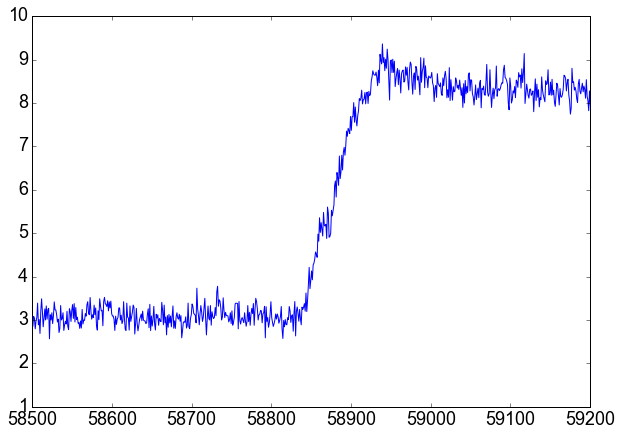

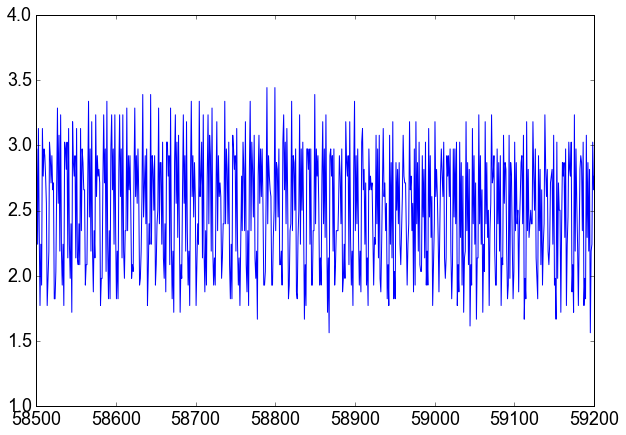

In [182]:
d['time'] = d['Timestamp'] - d['Timestamp'][0]

plt.plot(d['time'], d['Level'])
plt.xlim(58.5e3, 59.2e3)

plt.show()

plt.plot(d['time'], d['Flow'])
plt.xlim(58.5e3, 59.2e3)

plt.show()
